## PIMS Hackathon, Seattle 2025
### Project B - Preconditioners for Thermal Radiative Transfer
Packages: jupyter, numpy, matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from library import *

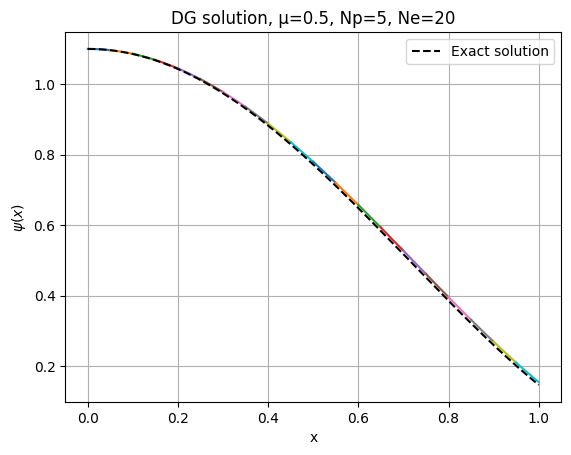

In [2]:
# ─── Example usage ───

# Parameters for the transport problem
μ       = 0.5
σ_t     = lambda x: x**2 + 1
source  = lambda x: (μ**3)*(2*x - 6.8*np.sin(2*x)) + (σ_t(x) * (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)))
inflow  = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))

# Mesh parameters
xs      = np.linspace(0, 1, 21) # Mesh points / element boundaries
Np      = 5                     # Legendre polynomials per element (basis size)

# Plot numerical solution against the exact solution (MMS)
ψ_MMS     = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))
ψ_weights = transport_direct_solve(μ, σ_t, source, inflow, Np, xs)
plot_solution(ψ_weights, xs, Np, μ=μ, exact_ψ_func=ψ_MMS)

# Spectrum of $(I-T)^{-1}$ and $I-T$
# Verify that $(I - \epsilon^{-2}D^{-1})(I-T)^{-1} = I + \mathcal{O}(\epsilon)$

## Definitions

$(I-T)^{-1} = \epsilon \alpha F_{||} - \epsilon^2 [ \frac{1}{3} M_{t}^{-1} (G - \frac{1}{2}F) M_{t}^{-1} (G - \frac{1}{2}F) - M_{t}^{-1}M_{a} ] + \mathcal{O}(\epsilon^3)$

$D = \alpha \epsilon^{-1} F_{||} - [ \frac{1}{3} M_{t}^{-1} (G - \frac{1}{2}F) M_{t}^{-1} (G - \frac{1}{2}F) - M_{t}^{-1}M_{a} ]$

$F^+,F^- \leftarrow $ assemble_face_matrices

$F = F^+ + F^-$

$F_{||} = F^+ - F^-$

$G \leftarrow $ assemble_deriv_matrix

$[M_{t/a}]_{mn} = \int_{x_e}^{x_{e+1}} \sigma_{t/a} v_{e,n} v_{e,m} dx$

$ \alpha = \frac{1}{2}\sum_{k} \omega_k |\mu_k| $

$ \epsilon \leftarrow $ from user as a hyperparameter


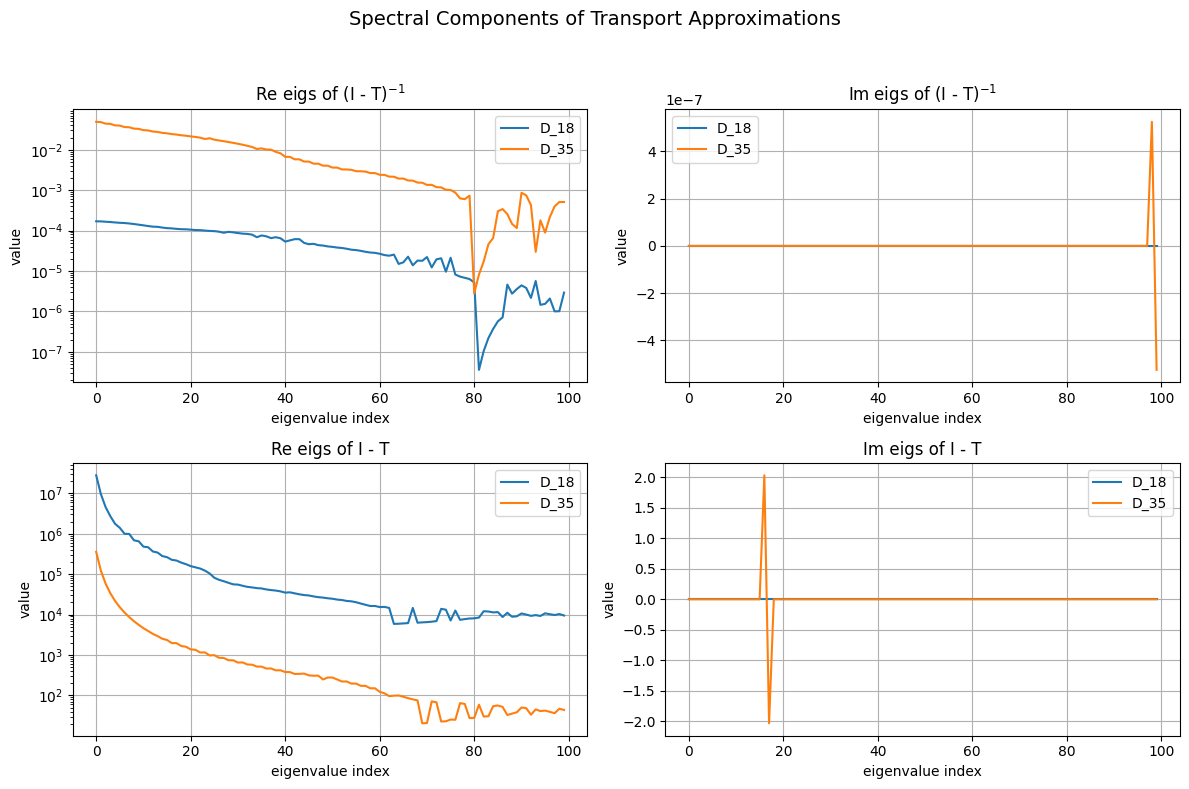

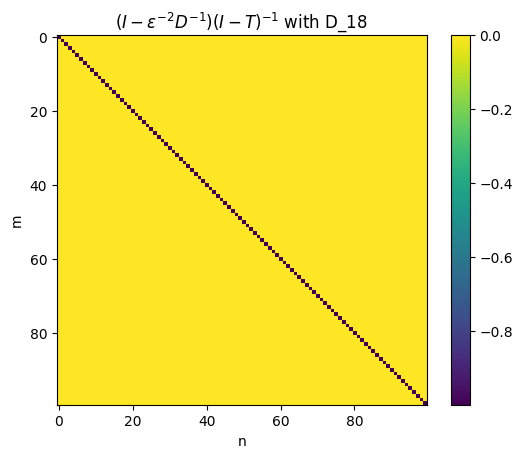

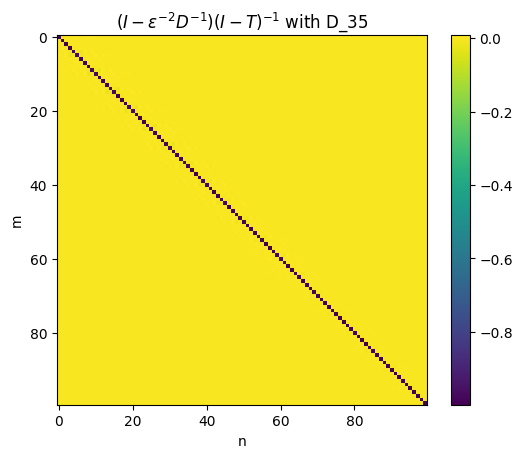

In [18]:
# Parameters for the transport problem
μ       = 0.5
σ_t     = lambda x: x**2 + 1
σ_a     = lambda x: x**2 + 1

# Mesh parameters
xs      = np.linspace(0, 1, 21) # Mesh points / element boundaries
Np      = 5                     # Legendre polynomials per element (basis size)
for_TSA = False

# Set \epsilon hyperparameter
epsilon = 1e-3

# Get F, F_{||} from F^+ and F^- via assemble_face_matrices
F_plus, F_minus = assemble_face_matrices(Np, xs, for_TSA=for_TSA)
F = F_plus + F_minus
F_parallel = F_plus - F_minus

# Get G from assemble_deriv_matrix
G = assemble_deriv_matrix(Np, xs)

# Get M_t/a via sigma_t/a
M_t = assemble_mass_matrix(σ_t, Np, xs)
M_a = assemble_mass_matrix(σ_a, Np, xs)

# Get alpha from omega_k and mu_k
N_mu = 3*Np
mu_k, w_k = gausslegendre(N_mu)
alpha = 0.5 * np.dot(w_k, np.abs(mu_k))

# Precompute M_t_inv and (G - 1/2 F)
M_t_inv = np.linalg.inv(M_t)
G_minus_half_of_F = G - 0.5*F

# Compute D from equations 18 and 35
D_18 = (1.0/3.0)*G_minus_half_of_F.T @ M_t_inv @ G_minus_half_of_F + alpha*F_parallel + M_a
D_35 = (alpha/epsilon)*F_parallel - ((1.0/3.0)*(M_t_inv @ G_minus_half_of_F @ M_t_inv @ G_minus_half_of_F) - (M_t_inv @ M_a))


def plot_D_spectrum(D_dict, epsilon):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Spectral Components of Transport Approximations", fontsize=14)

    # First plot: real part of eigenvalues of (I - T)^(-1) ≈ ε² D
    ax = axes[0][0]
    for label in D_dict:
        D = D_dict[label]
        matrix = epsilon**2 * D
        eigvals = np.linalg.eigvals(matrix)
        real_vals = np.real(eigvals)
        ax.plot(range(len(real_vals)), real_vals, label=label)
    ax.set_title('Re eigs of (I - T)$^{-1}$')
    ax.set_xlabel('eigenvalue index')
    ax.set_ylabel('value')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

    # Second plot: imaginary part of eigenvalues of (I - T)^(-1)
    ax = axes[0][1]
    for label in D_dict:
        D = D_dict[label]
        matrix = epsilon**2 * D
        eigvals = np.linalg.eigvals(matrix)
        imag_vals = np.imag(eigvals)
        ax.plot(range(len(imag_vals)), imag_vals, label=label)
    ax.set_title('Im eigs of (I - T)$^{-1}$')
    ax.set_xlabel('eigenvalue index')
    ax.set_ylabel('value')
    ax.legend()
    ax.grid(True)

    # Third plot: real part of eigenvalues of I - T ≈ (ε² D)^(-1)
    ax = axes[1][0]
    for label in D_dict:
        D = D_dict[label]
        matrix = np.linalg.inv(epsilon**2 * D)
        eigvals = np.linalg.eigvals(matrix)
        real_vals = np.real(eigvals)
        ax.plot(range(len(real_vals)), real_vals, label=label)
    ax.set_title('Re eigs of I - T')
    ax.set_xlabel('eigenvalue index')
    ax.set_ylabel('value')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

    # Fourth plot: imaginary part of eigenvalues of I - T
    ax = axes[1][1]
    for label in D_dict:
        D = D_dict[label]
        matrix = np.linalg.inv(epsilon**2 * D)
        eigvals = np.linalg.eigvals(matrix)
        imag_vals = np.imag(eigvals)
        ax.plot(range(len(imag_vals)), imag_vals, label=label)
    ax.set_title('Im eigs of I - T')
    ax.set_xlabel('eigenvalue index')
    ax.set_ylabel('value')
    ax.legend()
    ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_elements_of_matrix_mul(D_dict, epsilon):
    for D_str in D_dict.keys():
        if D_str == 'D_35':
            D = D_dict[D_str]
        else:
            D = D_dict[D_str]
        I_minus_T_inv_perturbation = (epsilon**2)*D

        n = D.shape[0]
        I = np.eye(n)
        mat_mul = (I - (epsilon**-2)*np.linalg.inv(D)) @ I_minus_T_inv_perturbation
        plt.imshow(mat_mul)
        plt.colorbar()
        plt.xlabel('n')
        plt.ylabel('m')
        plt.title(r'$(I - \epsilon^{-2}D^{-1})(I-T)^{-1}$ with '+D_str)
        
        plt.show()

D_dict = {
    'D_18': D_18,
    'D_35': D_35}

plot_D_spectrum(D_dict, epsilon)
plot_elements_of_matrix_mul(D_dict, epsilon)